# 介紹
本專案使用了github之公開code，撈取目標股票及時價格，並在股價波動時推送消息
引用資料: https://github.com/Asoul/tsrtc/blob/master/crawl.py#L38

安裝套件

In [ ]:
!pip install schedule
import schedule
import time
import json
import requests
import threading

使用gtihub上提供的code

In [ ]:
def get_stock_price(targets):
    if isinstance(targets, int):
        targets = [targets]
    endpoint = 'http://mis.twse.com.tw/stock/api/getStockInfo.jsp'

    # 記錄每支股票的最後價格和最後檢查時間
    last_prices = {target: None for target in targets}
    last_check_times = {target: None for target in targets}

    while True:
        timestamp = int(time.time() * 1000 + 1000000)
        channels = '|'.join('tse_{}.tw'.format(target) for target in targets)
        query = '{}?_={}&ex_ch={}'.format(endpoint, timestamp, channels)
        try:
            # Get original page to get session
            req = requests.session()
            req.get('http://mis.twse.com.tw/stock/index.jsp',
                    headers={'Accept-Language': 'zh-TW'})
            response = req.get(query)
            content = json.loads(response.text)
        except Exception as err:
            print(err)
            data = []
        else:
            data = content['msgArray']

        # 打印出過程和股票價格
        for stock in data:
            current_price = float(stock['z'])
            target = int(stock['c'])
            print(f"Time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}")
            print(f"Stock: {target}")
            print(f"Price: {current_price}")
            print('---')

            last_price = last_prices[target]
            last_check_time = last_check_times[target]
            current_time = time.time()

            # 如果是第一次獲取數據，記錄當前價格和時間
            if last_price is None:
                last_prices[target] = current_price
                last_check_times[target] = current_time
                continue

            # 檢查價格變動
            price_change = abs(current_price - last_price)
            time_elapsed = current_time - last_check_time
            price_trend = current_price - last_price
            # 設定條件: 如果在10分鐘內價格變動超過5元時推播訊息
            if price_change >= 5 and time_elapsed <= 600:
                notify_url = 'https://notify-api.line.me/api/notify'
                token = 'RIDNYav7Tr4aRaALwt244MiXg01tEJVALqrdU0w3ZKh'
                headers = {
                    "Authorization": "Bearer " + token
                }
                if price_trend<0:
                  data = {
                      "message": "10分鐘內價格變動超過5元\n代號 :{}\n趨勢: 正在下跌 \n目前價格: {}".format(targets[0],current_price)
                  }
                else:
                  data = {
                      "message": "10分鐘內價格變動超過5元\n代號 :{}\n趨勢: 正在上漲 \n目前價格: {}".format(targets[0],current_price)
                  }
                data = requests.post(notify_url, headers=headers, data=data)
                continue

            # 更新最後價格和最後檢查時間
            last_prices[target] = current_price
            last_check_times[target] = current_time
        # 每秒執行取得股價
        time.sleep(1)

# 選定目標股票並執行函式
get_stock_price(2454)

# 效果展示  
因colab受限，在visual studio code上執行

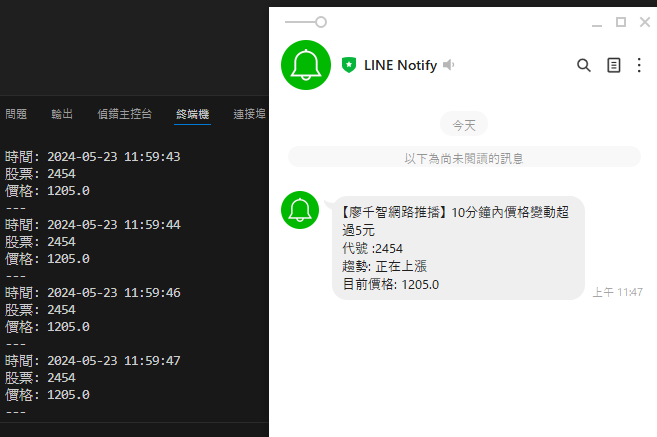